# Kammeröffnungs-Suche mit schichtbasiertem Ansatz

Dieses Notebook implementiert das neue Verfahren zur Erkennung von Kammeröffnungen:
1. Voxelisierung des 3D-Objekts entlang der Anschlussvektor-Achse
2. Berechnung des 2D Boundary (mit dilate)
3. Extraktion aller 2D-Schichten (Stufen) von Stufe 0 bis Max Stufe
4. Binary Search zur Öffnungserkennung (FloodFill + Randanalyse)

## 1. Imports und Setup

In [1]:
import os
import json
import numpy as np
import trimesh
import open3d as o3d
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.transform import Rotation
from ipyfilechooser import FileChooser
from IPython.display import display
import ipywidgets as widgets

%matplotlib inline

print("✓ Alle Module erfolgreich importiert")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✓ Alle Module erfolgreich importiert


## 2. JSON-Datei auswählen

In [3]:
json_chooser = FileChooser(
    path='Data',
    filename='',
    title='<b>JSON-Datei mit 3D-Daten auswählen</b>',
    show_hidden=False,
    select_default=False,
    filter_pattern=['*.json']
)

display(json_chooser)

FileChooser(path='C:\Users\LocalUser\Desktop\ConnectionPoins\Data', filename='', title='<b>JSON-Datei mit 3D-D…

In [4]:
json_file = json_chooser.selected
print(f"JSON-Datei: {json_file}")

if not json_file:
    print("⚠ Bitte wählen Sie eine JSON-Datei aus!")

JSON-Datei: C:\Users\LocalUser\Desktop\ConnectionPoins\DataSet\PXC.3211814_ElectricalTerminal_ElectricalTerminal.json


## 3. Hilfsfunktionen (Basis)

In [6]:
def load_json_data(json_file_path):
    if not os.path.exists(json_file_path):
        raise FileNotFoundError(f"JSON-Datei nicht gefunden: {json_file_path}")
    
    print(f"Lade JSON-Datei: {json_file_path}")
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    if 'Graphic3d' not in data or 'ConnectionPoints' not in data:
        raise ValueError("JSON-Datei muss 'Graphic3d' und 'ConnectionPoints' enthalten!")
    
    graphic3d = data['Graphic3d']
    points = graphic3d['Points']
    vertices = np.array([[p['X'], p['Y'], p['Z']] for p in points])
    indices = graphic3d['Indices']
    faces = np.array(indices).reshape(-1, 3)
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    
    vectors = [{
        'id': cp['Index'],
        'name': cp.get('Name', f"Point_{cp['Index']}"),
        'position': {'x': cp['Point']['X'], 'y': cp['Point']['Y'], 'z': cp['Point']['Z']},
        'direction': {'x': cp['InsertDirection']['X'], 'y': cp['InsertDirection']['Y'], 'z': cp['InsertDirection']['Z']}
    } for cp in data['ConnectionPoints']]
    
    print(f"✓ Mesh: {len(vertices)} Vertices, {len(faces)} Faces")
    print(f"✓ ConnectionPoints: {len(vectors)} Anschlusspunkte")
    return mesh, vectors

def rotate_mesh_to_align_vector(mesh, direction_vector, target_direction=np.array([0, 0, 1])):
    if isinstance(direction_vector, dict):
        dir_vec = np.array([direction_vector['x'], direction_vector['y'], direction_vector['z']])
    else:
        dir_vec = np.array(direction_vector)
    
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    target_direction = target_direction / np.linalg.norm(target_direction)
    rotation_axis = np.cross(dir_vec, target_direction)
    rotation_axis_norm = np.linalg.norm(rotation_axis)
    
    if rotation_axis_norm < 1e-6:
        if np.dot(dir_vec, target_direction) > 0:
            return mesh.copy(), np.eye(4)
        rotation_axis = np.array([1, 0, 0]) if abs(dir_vec[0]) < 0.9 else np.array([0, 1, 0])
        rotation_angle = np.pi
    else:
        rotation_axis = rotation_axis / rotation_axis_norm
        rotation_angle = np.arccos(np.clip(np.dot(dir_vec, target_direction), -1.0, 1.0))
    
    rotation = Rotation.from_rotvec(rotation_angle * rotation_axis)
    rotation_matrix = np.eye(4)
    rotation_matrix[:3, :3] = rotation.as_matrix()
    rotated_mesh = mesh.copy()
    rotated_mesh.apply_transform(rotation_matrix)
    print(f"✓ Mesh rotiert: Winkel = {np.degrees(rotation_angle):.2f}°")
    return rotated_mesh, rotation_matrix

def mesh_to_voxels(mesh, voxel_resolution=800):
    o3d_mesh = o3d.geometry.TriangleMesh()
    o3d_mesh.vertices = o3d.utility.Vector3dVector(mesh.vertices)
    o3d_mesh.triangles = o3d.utility.Vector3iVector(mesh.faces)
    o3d_mesh.compute_vertex_normals()
    voxel_size = np.max(mesh.bounds[1] - mesh.bounds[0]) / voxel_resolution
    voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(o3d_mesh, voxel_size=voxel_size)
    print(f"✓ Voxel Grid: {len(voxel_grid.get_voxels())} Voxel")
    return voxel_grid, voxel_size

def extract_voxel_grid_as_3d_array(voxel_grid):
    voxels = voxel_grid.get_voxels()
    if len(voxels) == 0:
        return None, None, None
    
    voxel_coords = [(*voxel_grid.get_voxel_center_coordinate(v.grid_index), *v.grid_index) for v in voxels]
    voxel_coords = np.array(voxel_coords)
    world_coords = voxel_coords[:, :3]
    grid_indices = voxel_coords[:, 3:].astype(int)
    
    ix_min, iy_min, iz_min = grid_indices.min(axis=0)
    ix_max, iy_max, iz_max = grid_indices.max(axis=0)
    grid_shape = (ix_max - ix_min + 1, iy_max - iy_min + 1, iz_max - iz_min + 1)
    voxel_array = np.zeros(grid_shape, dtype=bool)
    
    for coord in grid_indices:
        ix, iy, iz = coord - np.array([ix_min, iy_min, iz_min])
        voxel_array[ix, iy, iz] = True
    
    bounds = (*world_coords.min(axis=0), *world_coords.max(axis=0))
    print(f"✓ 3D Array: {grid_shape}")
    return voxel_array, bounds, grid_shape

def create_2d_boundary(voxel_array):
    projection = np.any(voxel_array, axis=2)
    projection_image = (projection * 255).astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(projection_image, kernel, iterations=2)
    grad_x = cv2.Sobel(dilated, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(dilated, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    boundary_image = (gradient_magnitude > gradient_magnitude.max() * 0.3).astype(np.uint8) * 255
    return boundary_image, projection_image

def find_connection_point_z_level(connection_point, bounds, grid_shape):
    z_min, z_max = bounds[2], bounds[5]
    z_normalized = (connection_point['z'] - z_min) / (z_max - z_min)
    z_level = int(z_normalized * (grid_shape[2] - 1))
    return max(0, min(grid_shape[2] - 1, z_level))

def extract_2d_layer(voxel_array, z_level):
    if 0 <= z_level < voxel_array.shape[2]:
        return (voxel_array[:, :, z_level] * 255).astype(np.uint8)
    return None

print("✓ Hilfsfunktionen (Basis) definiert")

✓ Hilfsfunktionen (Basis) definiert


## 4. JSON-Datei laden

In [7]:
mesh, vectors = load_json_data(json_file)

if vectors:
    print("\nVerfügbare Anschlusspunkte:")
    for v in vectors:
        print(f"  P{v['id']}: {v['name']} - ({v['position']['x']:.4f}, {v['position']['y']:.4f}, {v['position']['z']:.4f})")

Lade JSON-Datei: C:\Users\LocalUser\Desktop\ConnectionPoins\DataSet\PXC.3211814_ElectricalTerminal_ElectricalTerminal.json
✓ Mesh: 356 Vertices, 692 Faces
✓ ConnectionPoints: 2 Anschlusspunkte

Verfügbare Anschlusspunkte:
  P0:  - (22.2822, -8.4000, 49.6200)
  P1:  - (-21.2178, -8.4000, 49.6200)


## 5. Visualisierung: Original Mesh

In [8]:
o3d_mesh = o3d.geometry.TriangleMesh()
o3d_mesh.vertices = o3d.utility.Vector3dVector(mesh.vertices)
o3d_mesh.triangles = o3d.utility.Vector3iVector(mesh.faces)
o3d_mesh.compute_vertex_normals()
o3d_mesh.paint_uniform_color([0.7, 0.7, 0.7])

print("Zeige Original-Mesh (Fenster schließen zum Fortfahren)...")
o3d.visualization.draw_geometries([o3d_mesh], window_name="Original Mesh", width=1024, height=768)

Zeige Original-Mesh (Fenster schließen zum Fortfahren)...
[Open3D WARNING] GLFW Error: WGL: The driver does not appear to support OpenGL
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


## 6. Anschlusspunkt auswählen

In [9]:
if vectors:
    dropdown = widgets.Dropdown(
        options=[(f"P{v['id']} - {v['name']}", v['id']) for v in vectors],
        description='Anschlusspunkt:',
        style={'description_width': 'initial'}
    )
    display(dropdown)

Dropdown(description='Anschlusspunkt:', options=(('P0 - ', 0), ('P1 - ', 1)), style=DescriptionStyle(descripti…

## 7. Mesh-Rotation

In [10]:
vector = next((v for v in vectors if v['id'] == dropdown.value), None)

if vector:
    print(f"\nVerarbeite P{vector['id']} - {vector['name']}")
    rotated_mesh, rotation_matrix = rotate_mesh_to_align_vector(mesh, vector['direction'])
    
    cp_world = np.array([vector['position']['x'], vector['position']['y'], vector['position']['z'], 1.0])
    rotated_cp = rotation_matrix @ cp_world
    rotated_connection_dict = {'x': rotated_cp[0], 'y': rotated_cp[1], 'z': rotated_cp[2]}


Verarbeite P0 - 
✓ Mesh rotiert: Winkel = 90.00°


## 8. Visualisierung: Rotiertes Mesh

In [13]:
o3d_rotated = o3d.geometry.TriangleMesh()
o3d_rotated.vertices = o3d.utility.Vector3dVector(rotated_mesh.vertices)
o3d_rotated.triangles = o3d.utility.Vector3iVector(rotated_mesh.faces)
o3d_rotated.compute_vertex_normals()
o3d_rotated.paint_uniform_color([0.5, 0.7, 0.9])

coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=max(rotated_mesh.bounds[1] - rotated_mesh.bounds[0]) * 0.3, origin=[0,0,0])

sphere = o3d.geometry.TriangleMesh.create_sphere(radius=max(rotated_mesh.bounds[1] - rotated_mesh.bounds[0]) * 0.02)
sphere.translate([rotated_connection_dict['x'], rotated_connection_dict['y'], rotated_connection_dict['z']])
sphere.paint_uniform_color([1.0, 0.0, 0.0])

arrow_start = np.array([rotated_connection_dict['x'], rotated_connection_dict['y'], rotated_connection_dict['z']])
arrow_end = arrow_start + np.array([0, 0, max(rotated_mesh.bounds[1] - rotated_mesh.bounds[0]) * 0.15])
line_set = o3d.geometry.LineSet()
line_set.points = o3d.utility.Vector3dVector([arrow_start, arrow_end])
line_set.lines = o3d.utility.Vector2iVector([[0, 1]])
line_set.colors = o3d.utility.Vector3dVector([[1.0, 0.0, 0.0]])

print("\nZeige rotiertes Mesh:")
print("  - Rote Kugel: Anschlusspunkt")
print("  - Rote Linie: Insertionsrichtung (Z)")
print("  - RGB-Achsen: Koordinatensystem")
o3d.visualization.draw_geometries([o3d_rotated, coord_frame, sphere, line_set], 
                                  window_name="Rotiertes Mesh", width=1024, height=768)


Zeige rotiertes Mesh:
  - Rote Kugel: Anschlusspunkt
  - Rote Linie: Insertionsrichtung (Z)
  - RGB-Achsen: Koordinatensystem
[Open3D WARNING] GLFW Error: WGL: The driver does not appear to support OpenGL
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


## 9. Voxelisierung und Boundary

In [14]:
voxel_grid, voxel_size = mesh_to_voxels(rotated_mesh, voxel_resolution=800)
voxel_array, bounds, grid_shape = extract_voxel_grid_as_3d_array(voxel_grid)

if voxel_array is not None:
    json_name = os.path.splitext(os.path.basename(json_file))[0]
    output_dir = os.path.join("Data", f"{json_name}_P{vector['id']}_search")
    os.makedirs(output_dir, exist_ok=True)
    
    boundary_image, projection_image = create_2d_boundary(voxel_array)
    cv2.imwrite(os.path.join(output_dir, f"{json_name}_P{vector['id']}_boundary.png"), boundary_image)
    cv2.imwrite(os.path.join(output_dir, f"{json_name}_P{vector['id']}_projection.png"), projection_image)
    
    z_start = find_connection_point_z_level(rotated_connection_dict, bounds, grid_shape)
    z_end = grid_shape[2] - 1
    print(f"\nZ-Bereich: {z_start} bis {z_end} ({z_end - z_start + 1} Stufen)")

✓ Voxel Grid: 1267512 Voxel
✓ 3D Array: (np.int64(801), np.int64(114), np.int64(586))

Z-Bereich: 498 bis 585 (88 Stufen)


## 10. Layer speichern

In [15]:
layers_dir = os.path.join(output_dir, "layers")
os.makedirs(layers_dir, exist_ok=True)

saved_files = []
for z_level in range(z_start, z_end + 1):
    layer_image = extract_2d_layer(voxel_array, z_level)
    if layer_image is not None:
        filename = os.path.join(layers_dir, f"{json_name}_P{vector['id']}_layer_{z_level:04d}.png")
        cv2.imwrite(filename, layer_image)
        saved_files.append(filename)

print(f"✓ {len(saved_files)} Layer gespeichert in {layers_dir}")

✓ 88 Layer gespeichert in Data\PXC.3211814_ElectricalTerminal_ElectricalTerminal_P0_search\layers


## 11. Visualisierung: Projektion und Boundary

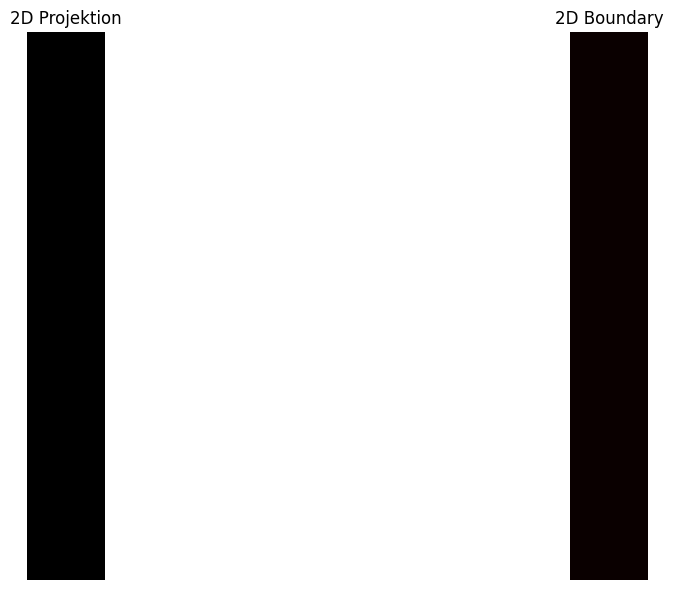

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(projection_image, cmap='gray', origin='lower')
axes[0].set_title('2D Projektion')
axes[0].axis('off')
axes[1].imshow(boundary_image, cmap='hot', origin='lower')
axes[1].set_title('2D Boundary')
axes[1].axis('off')
plt.tight_layout()
plt.show()

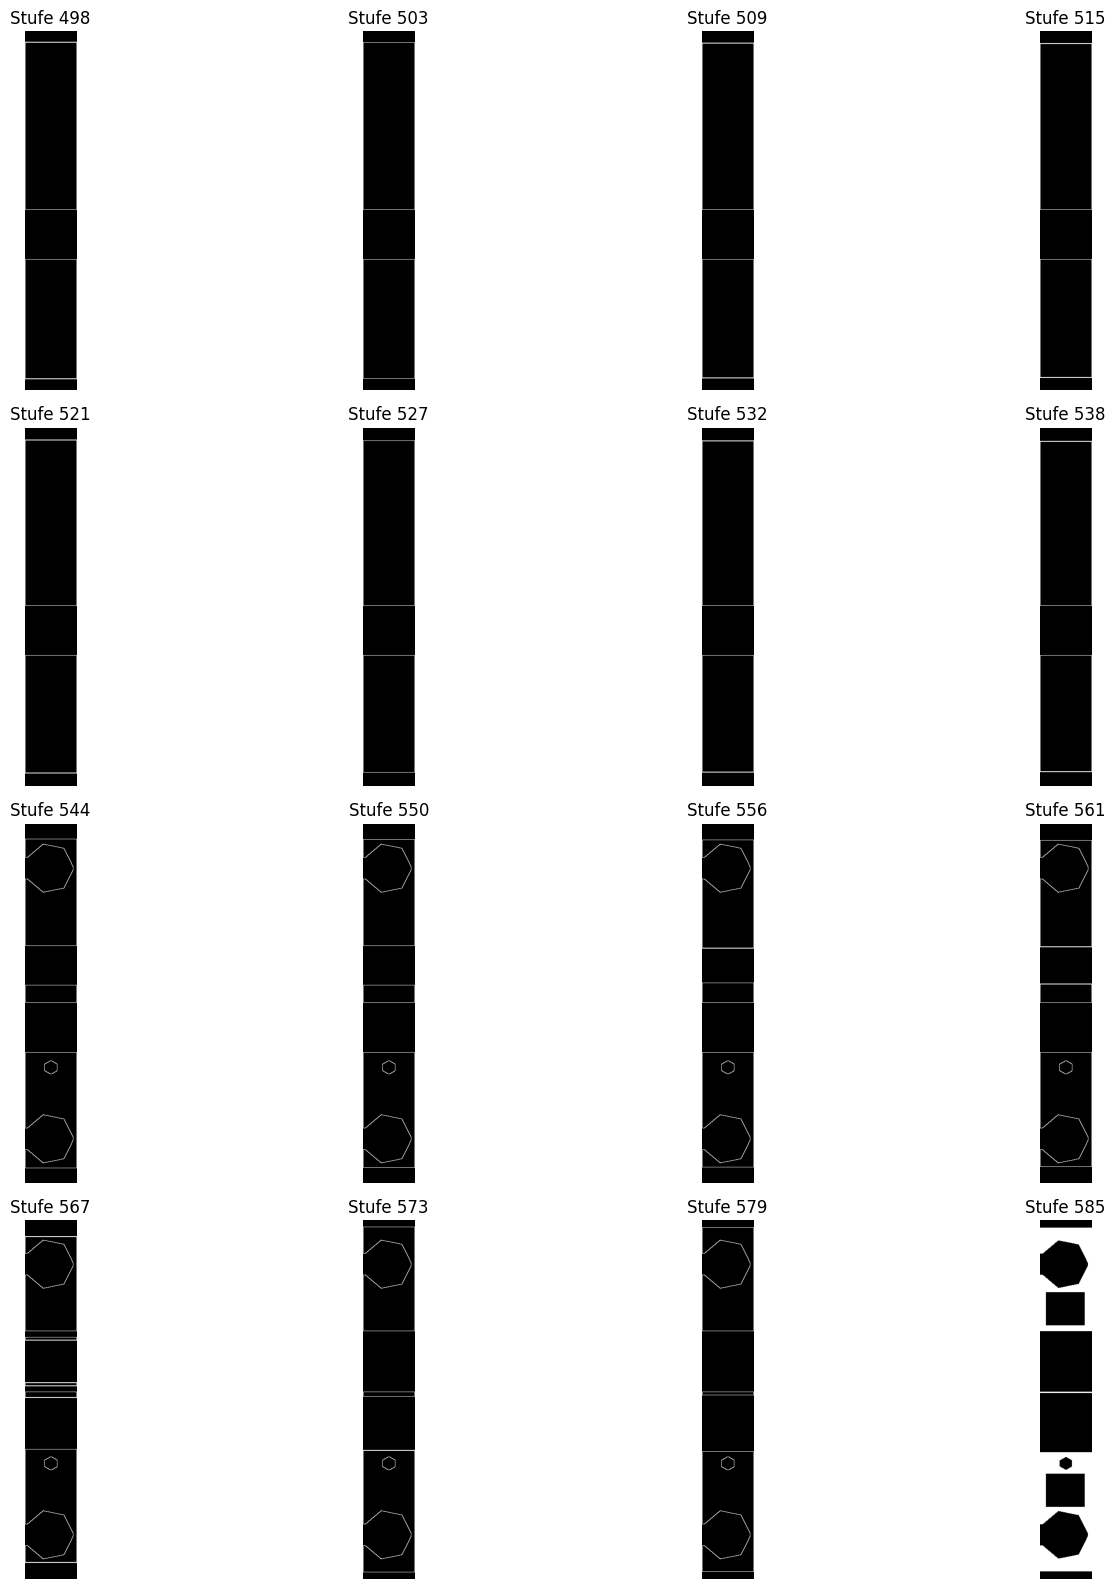

In [17]:
sample_indices = np.linspace(z_start, z_end, min(16, z_end - z_start + 1), dtype=int)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for idx, z_level in enumerate(sample_indices):
    axes[idx].imshow(extract_2d_layer(voxel_array, z_level), cmap='gray', origin='lower')
    axes[idx].set_title(f'Stufe {z_level}')
    axes[idx].axis('off')

for idx in range(len(sample_indices), 16):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 12. Hilfsfunktionen für Binary Search

In [18]:
def find_connection_point_2d(connection_point_3d, bounds, grid_shape):
    """Konvertiert 3D Anschlusspunkt zu 2D Koordinaten im Layer-Bild"""
    x_min, x_max, y_min, y_max, z_min, z_max = bounds
    x_normalized = (connection_point_3d['x'] - x_min) / (x_max - x_min)
    y_normalized = (connection_point_3d['y'] - y_min) / (y_max - y_min)
    x_2d = int(x_normalized * (grid_shape[0] - 1))
    y_2d = int(y_normalized * (grid_shape[1] - 1))
    x_2d = max(0, min(grid_shape[0] - 1, x_2d))
    y_2d = max(0, min(grid_shape[1] - 1, y_2d))
    return (x_2d, y_2d)

def investigate_layer(voxel_array, z_level, boundary_image, connection_point_2d, verbose=False):
    """
    Untersucht ein Layer mit FloodFill und Randanalyse
    Returns: (is_potential_opening, chamber_percentage, filled_mask)
    """
    layer_image = extract_2d_layer(voxel_array, z_level)
    if layer_image is None:
        return False, 0.0, None
    
    # Verschmelze Layer mit Boundary
    merged = cv2.bitwise_or(layer_image, boundary_image)
    
    # FloodFill
    h, w = merged.shape
    mask = np.zeros((h + 2, w + 2), np.uint8)
    filled = merged.copy()
    seed_point = (connection_point_2d[0], connection_point_2d[1])
    cv2.floodFill(filled, mask, seed_point, 128, loDiff=0, upDiff=0,
                  flags=cv2.FLOODFILL_MASK_ONLY | (255 << 8))
    filled_mask = mask[1:-1, 1:-1]
    
    # Rand der gefüllten Region
    kernel = np.ones((3, 3), np.uint8)
    dilated_filled = cv2.dilate(filled_mask, kernel, iterations=1)
    edge_mask = cv2.bitwise_and(dilated_filled, cv2.bitwise_not(filled_mask))
    
    # Analyse: Kammer vs. Boundary
    edge_pixels = edge_mask > 0
    total_edge_pixels = edge_pixels.sum()
    
    if total_edge_pixels == 0:
        if verbose:
            print(f"  Layer {z_level}: Keine Randpixel gefunden")
        return False, 0.0, filled_mask
    
    chamber_edge_pixels = cv2.bitwise_and(layer_image, edge_mask)
    chamber_count = (chamber_edge_pixels > 0).sum()
    chamber_percentage = (chamber_count / total_edge_pixels) * 100.0
    is_potential_opening = chamber_percentage > 50.0
    
    if verbose:
        print(f"  Layer {z_level}: Rand={total_edge_pixels}, "
              f"Kammer={chamber_count}, {chamber_percentage:.1f}% → "
              f"{'ÖFFNUNG' if is_potential_opening else 'geschlossen'}")
    
    return is_potential_opening, chamber_percentage, filled_mask

def binary_search_opening(voxel_array, boundary_image, connection_point_2d,
                         z_start, z_end, verbose=True):
    """
    Binary Search für Kammeröffnung
    Returns: (opening_z_level, investigated_layers)
    """
    print(f"\nStarte Binary Search für Kammeröffnung...")
    print(f"  Bereich: Layer {z_start} (Anschluss) bis {z_end} (Max)")
    
    investigated_layers = []
    last_opening_z = None
    last_opening_percentage = 0.0
    
    lower = z_start
    upper = z_end
    iteration = 0
    max_iterations = int(np.ceil(np.log2(z_end - z_start + 1))) + 5
    
    while lower <= upper and iteration < max_iterations:
        iteration += 1
        
        if iteration == 1:
            current_z = upper  # Start mit max layer
        else:
            current_z = (lower + upper) // 2
        
        if verbose:
            print(f"\nIteration {iteration}: Untersuche Layer {current_z} (Bereich: {lower}-{upper})")
        
        is_opening, percentage, _ = investigate_layer(
            voxel_array, current_z, boundary_image, connection_point_2d, verbose=verbose
        )
        
        investigated_layers.append((current_z, is_opening, percentage))
        
        if is_opening:
            last_opening_z = current_z
            last_opening_percentage = percentage
            
            if iteration == 1:
                if verbose:
                    print(f"\n→ Max Layer {current_z} ist bereits Öffnung! Suche beendet.")
                break
            
            lower = current_z + 1
            if verbose:
                print(f"→ Öffnung gefunden! Suche weiter nach oben: {lower}-{upper}")
        else:
            upper = current_z - 1
            if verbose:
                print(f"→ Keine Öffnung. Suche weiter nach unten: {lower}-{upper}")
    
    if last_opening_z is not None:
        print(f"\n✓ Kammeröffnung gefunden bei Layer {last_opening_z}")
        print(f"  Kammer-Anteil am Rand: {last_opening_percentage:.1f}%")
        print(f"  Untersuchte Layers: {len(investigated_layers)}")
    else:
        print(f"\n✗ Keine Kammeröffnung gefunden")
    
    return last_opening_z, investigated_layers

print("✓ Binary Search Funktionen definiert")

✓ Binary Search Funktionen definiert


## 13. Binary Search ausführen

In [19]:
# Konvertiere Anschlusspunkt zu 2D
connection_point_2d = find_connection_point_2d(rotated_connection_dict, bounds, grid_shape)
print(f"Anschlusspunkt 2D: {connection_point_2d}")

# Binary Search
opening_z_level, investigated_layers = binary_search_opening(
    voxel_array, boundary_image, connection_point_2d,
    z_start, z_end, verbose=True
)

Anschlusspunkt 2D: (0, 0)

Starte Binary Search für Kammeröffnung...
  Bereich: Layer 498 (Anschluss) bis 585 (Max)

Iteration 1: Untersuche Layer 585 (Bereich: 498-585)
  Layer 585: Rand=114, Kammer=114, 100.0% → ÖFFNUNG

→ Max Layer 585 ist bereits Öffnung! Suche beendet.

✓ Kammeröffnung gefunden bei Layer 585
  Kammer-Anteil am Rand: 100.0%
  Untersuchte Layers: 1


## 14. Visualisierung: Binary Search Ergebnisse

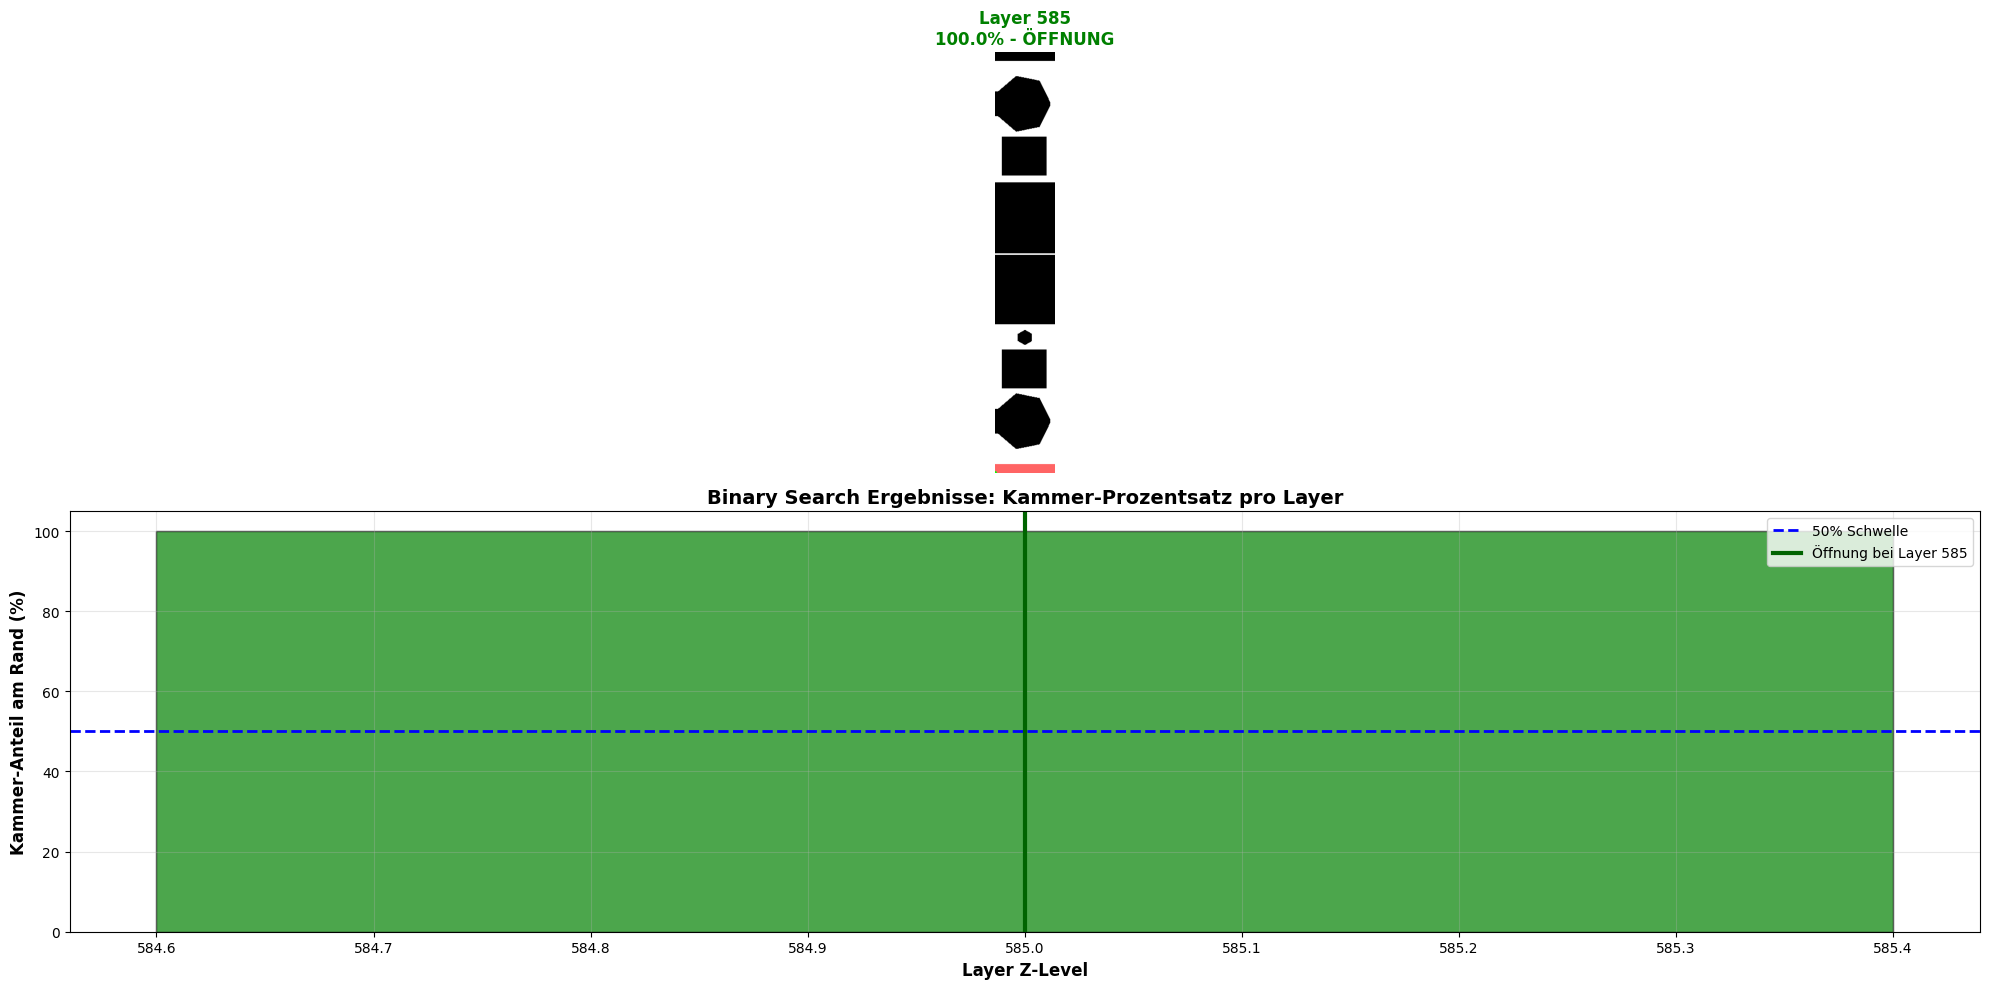


✓ Binary Search Visualisierung gespeichert: Data\PXC.3211814_ElectricalTerminal_ElectricalTerminal_P0_search\PXC.3211814_ElectricalTerminal_ElectricalTerminal_P0_binary_search_results.png


In [20]:
# Sortiere investigated_layers
investigated_layers_sorted = sorted(investigated_layers, key=lambda x: x[0])

# Erstelle Visualisierung
n_layers = len(investigated_layers_sorted)
fig = plt.figure(figsize=(20, 10))

# Zeile 1: Untersuchte Layers (max 8)
display_count = min(8, n_layers)
for i in range(display_count):
    z_level, is_opening, percentage = investigated_layers_sorted[i]
    ax = plt.subplot(2, display_count, i + 1)
    
    layer_image = extract_2d_layer(voxel_array, z_level)
    _, _, filled_mask = investigate_layer(voxel_array, z_level, boundary_image,
                                         connection_point_2d, verbose=False)
    
    # Kombiniere Layer (grau) + FloodFill (rot)
    display_image = np.zeros((*layer_image.shape, 3), dtype=np.uint8)
    display_image[:, :, 0] = layer_image
    display_image[:, :, 1] = layer_image
    display_image[:, :, 2] = layer_image
    
    if filled_mask is not None:
        display_image[filled_mask > 0] = [255, 100, 100]
    
    # Markiere Anschlusspunkt
    cv2.circle(display_image, connection_point_2d, 3, (0, 255, 0), -1)
    
    ax.imshow(display_image, origin='lower')
    title_color = 'green' if is_opening else 'red'
    status = 'ÖFFNUNG' if is_opening else 'geschlossen'
    ax.set_title(f'Layer {z_level}\n{percentage:.1f}% - {status}',
                color=title_color, fontweight='bold')
    ax.axis('off')

# Zeile 2: Graph
ax_graph = plt.subplot(2, 1, 2)
z_levels = [x[0] for x in investigated_layers_sorted]
percentages = [x[2] for x in investigated_layers_sorted]
colors = ['green' if x[1] else 'red' for x in investigated_layers_sorted]

ax_graph.bar(z_levels, percentages, color=colors, alpha=0.7, edgecolor='black')
ax_graph.axhline(y=50, color='blue', linestyle='--', linewidth=2, label='50% Schwelle')

if opening_z_level is not None:
    ax_graph.axvline(x=opening_z_level, color='darkgreen', linestyle='-',
                    linewidth=3, label=f'Öffnung bei Layer {opening_z_level}')

ax_graph.set_xlabel('Layer Z-Level', fontsize=12, fontweight='bold')
ax_graph.set_ylabel('Kammer-Anteil am Rand (%)', fontsize=12, fontweight='bold')
ax_graph.set_title('Binary Search Ergebnisse: Kammer-Prozentsatz pro Layer',
                  fontsize=14, fontweight='bold')
ax_graph.legend()
ax_graph.grid(True, alpha=0.3)
ax_graph.set_ylim([0, 105])

plt.tight_layout()
plt.show()

# Speichere Visualisierung
output_filename = os.path.join(output_dir, f"{json_name}_P{vector['id']}_binary_search_results.png")
fig.savefig(output_filename, dpi=150, bbox_inches='tight')
print(f"\n✓ Binary Search Visualisierung gespeichert: {output_filename}")

## 15. Zusammenfassung

In [21]:
print("="*60)
print("ZUSAMMENFASSUNG")
print("="*60)
print(f"Layer-Bilder: {len(saved_files)} gespeichert")
print(f"Untersuchte Layers (Binary Search): {len(investigated_layers)}")
if opening_z_level is not None:
    print(f"Kammeröffnung: Layer {opening_z_level}")
else:
    print(f"Kammeröffnung: Nicht gefunden")
print("="*60)

ZUSAMMENFASSUNG
Layer-Bilder: 88 gespeichert
Untersuchte Layers (Binary Search): 1
Kammeröffnung: Layer 585
